# Figure 2
Plots found in Figure 2 of the paper.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

filename = "data/MFI_with_RS_new_filtering.csv"
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [2]:
# We need to standardize the way in which we compile the time series of each patient:
# For missing Abs, we should add a 499,499,... or a NaN,NaN,... time series
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

def get_time_series(df, Ab_id, dummy_value_inter=499, dummy_value_whole=np.nan):    
    # Transform into datetime objects for sorting
    dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df['IL_DAT'].unique())]
    dates = sorted(dates)
    
    # Check if there is any value matching the ab id
    values = []
    if Ab_id in df['I_NAM'].values:
        for date in dates:
            str_date = datetime.datetime.strftime(date, '%d.%m.%Y')
            df_date = df[df['IL_DAT']==str_date]
            if Ab_id in df_date['I_NAM'].values:
                val = df_date[df_date['I_NAM'] == Ab_id]['I_VAL'].values
                values.append(float(val[0]))
            else:
                values.append(dummy_value_inter)
        return np.asarray(values), dates
    else:
        return dummy_value_whole*np.ones(len(dates)), dates

def get_evolution_df(df, complete=False, analysis_type='1'):
    evo_df = pd.DataFrame()
    if complete:
        # Need to check if we only consider type1 or type2 or both...
        if analysis_type == '1':
            # CAREFUL: There is no automatic check to verify...
            list_abs = ALL_ABS_TYP1 # Generate a ts for every ab
        elif analysis_type == '2':
            list_abs = ALL_ABS_TYP2
        else:
            list_abs = ALL_ABS
    else:
        list_abs = list(df['I_NAM'].unique()) 
    for ab_id in list_abs:
        ts, dates = get_time_series(df[df['TYP']=='Lumi-Single-Klasse'+analysis_type], ab_id, dummy_value_inter=499, dummy_value_whole=499)
        evo_df[ab_id] = ts
    dates = pd.DatetimeIndex(dates)
    evo_df = evo_df.set_index(dates)
    return evo_df

In [3]:
# Unfortunately patients have non-matching time series for the 2 classes of assays
# hence we will have two sets of time-series for each patients.
def filter_patients(df_in, analysis_type="1"):
    df_filtered_typ = df_in[df_in['TYP']=='Lumi-Single-Klasse'+ analysis_type]
    # Let's only keep patients with at least 2 measurements
    df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
    print('{} patients need to be excluded as they only have one date of measurements.'.format((df_n==1).sum()))
    df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
    return df_filtered_typ

df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


438

In [4]:
# Gather the signal differences and average them for all single measurements
tdifs = []
valdifs = []
kept_ids = []
for patid in df_filtered_typ1['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs.append(patient_ts.as_matrix()[1:,:]-patient_ts.as_matrix()[:-1,:])
        kept_ids.append(patid)
    except:
        continue

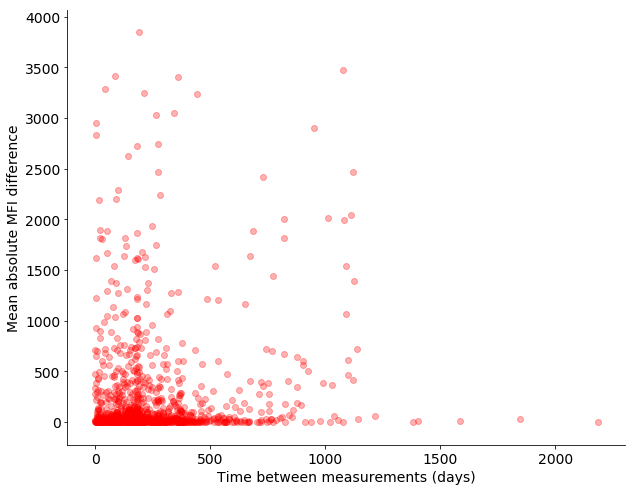

In [5]:
# Plot difference in signal vs difference in time, iterate through patients
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10,8))

for i, t in enumerate(tdifs):
    plt.scatter(t, [np.abs(x).mean(axis=0) for x in valdifs[i]], c='r', alpha=0.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time between measurements (days)')
plt.ylabel('Mean absolute MFI difference')
plt.rcParams.update({'font.size': 12})

There seems to be no relationship between the time between measurements and the change of MFI.


### Absolute mean value

In [6]:
# Take the mean absolute value across all antibodies
mean_absolute_vectors = [np.abs(x).T.mean(axis=0) for x in valdifs]

In [7]:
# Need to get a colorscale of the categorical values
# Equal size percentile
t = np.concatenate(tdifs)
lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq[(t>=lims[-1]).reshape(-1,)] = i+1

In [8]:
print(lims)
np.unique(class_label_eq)

[ 98.  175.  225.4 361.2]


array([0., 1., 2., 3., 4.])

In [9]:
print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))

There are 1265 total differences, 253.0 in each quantile.


In [10]:
class_label_eq = class_label_eq.astype(int)
class_dict_eq = {
    0: '<98 days',
    1: '98 days - 175 days',
    2: '176 days - 225 days',
    3: '226 days - 361 days',
    4: '> 361 days'
}
hue_order_eq=['<98 days','98 days - 175 days','176 days - 225 days','226 days - 361 days','> 361 days']
class_lab_eq = []
for c in class_label_eq:
    class_lab_eq.append(class_dict_eq[c])

In [11]:
# Plot again
a = np.concatenate(mean_absolute_vectors)
df_adhoc = pd.DataFrame(np.abs(a).T, columns=['Mean absolute MFI change between measurements'])
df_adhoc['Time between measurements'] = np.array(class_lab_eq)[np.ones_like(a).astype(bool)]

In [12]:
# Ideal cubehelix parameters: n_colors=5, start=0.3, rot=-0.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1
cubehelix_pal = sns.cubehelix_palette(5, start=.3, rot=-.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1)

In [13]:
def swarmplot(df_adhoc, hue_order_eq, cubehelix_pal, maxval, savename=None):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(8,8))
    sns.swarmplot(x = 'Mean absolute MFI change between measurements', y=[""]*len(df_adhoc), hue='Time between measurements', 
                  data=df_adhoc, hue_order=hue_order_eq, alpha=0.95, 
                  palette=cubehelix_pal, size=6)
    # sns.color_palette()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0,maxval)

    if savename is not None:
        fig.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
        fig.savefig(f'{savename}.png', bbox_inches='tight')
    
    plt.rcParams.update({'font.size': 12})

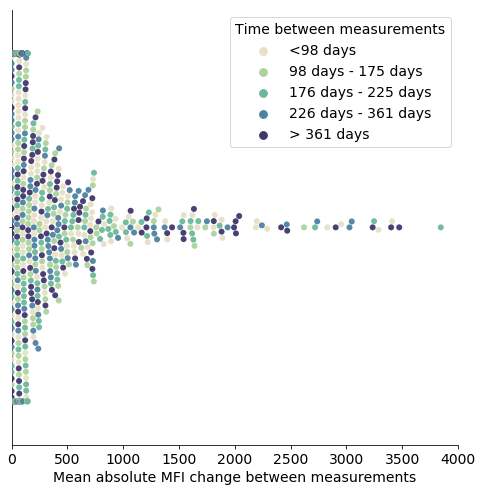

In [14]:
swarmplot(df_adhoc, hue_order_eq, cubehelix_pal, 4000,
          savename='paper/figures/plots/swarmplot_mean_absolute_mfi_change_cblind')

In [16]:
def swarmboxplot(df_adhoc, hue_order_eq, cubehelix_pal, maxval, savename=None):
    # Try alternative visualization
    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(12,8))
    sns.swarmplot(x="Mean absolute MFI change between measurements", y="Time between measurements", 
                  data=df_adhoc, order=hue_order_eq, alpha=0.95, palette=cubehelix_pal, orient='h')
    ax = sns.boxplot(x="Mean absolute MFI change between measurements", y="Time between measurements", 
                data=df_adhoc, order=hue_order_eq, color='black',orient='h', ax=ax, fliersize=0)
    plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(ax.lines, color='k')
    # plt.yticks(rotation=90)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0,maxval)
    plt.tight_layout()
    
    if savename is not None:
        fig.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
        fig.savefig(f'{savename}.png', bbox_inches='tight')
    plt.rcParams.update({'font.size': 12})


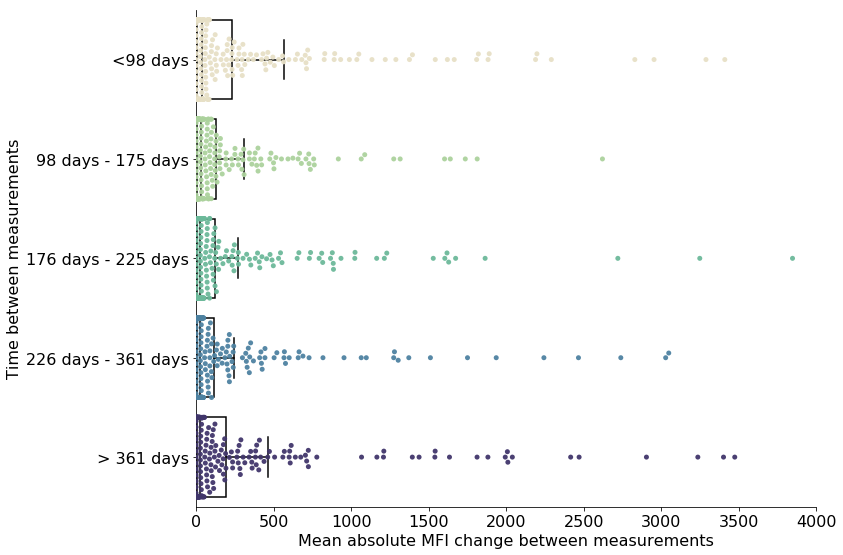

In [18]:
swarmboxplot(df_adhoc, hue_order_eq, cubehelix_pal, maxval=4000,
            savename='paper/figures/plots/swarmboxplot_mean_absolute_mfi_change_cblind')

In [19]:
# Statistical tests
# Test the distribution differences using indep ttest
from scipy.stats import ttest_ind

def conduct_test(df_adhoc, hue_order_eq):
    vs = []
    for c in hue_order_eq:
        vs.append(df_adhoc[df_adhoc['Time between measurements']==c]['Mean absolute MFI change between measurements'].as_matrix())
    # Conduct the test for each pair
    for i in range(5):
        for j in range(i+1,5):
            print('{} vs {}:'.format(hue_order_eq[i], hue_order_eq[j]))
            t, p = ttest_ind(vs[i], vs[j], equal_var=False, nan_policy='omit')
            print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))
conduct_test(df_adhoc, hue_order_eq)

<98 days vs 98 days - 175 days:
	t-score: 2.604, p-val: 0.00954
<98 days vs 176 days - 225 days:
	t-score: 1.402, p-val: 0.16152
<98 days vs 226 days - 361 days:
	t-score: 1.757, p-val: 0.07960
<98 days vs > 361 days:
	t-score: 0.108, p-val: 0.91378
98 days - 175 days vs 176 days - 225 days:
	t-score: -1.106, p-val: 0.26924
98 days - 175 days vs 226 days - 361 days:
	t-score: -0.732, p-val: 0.46471
98 days - 175 days vs > 361 days:
	t-score: -2.358, p-val: 0.01884
176 days - 225 days vs 226 days - 361 days:
	t-score: 0.350, p-val: 0.72639
176 days - 225 days vs > 361 days:
	t-score: -1.238, p-val: 0.21631
226 days - 361 days vs > 361 days:
	t-score: -1.576, p-val: 0.11580


In [20]:
# Test for clinical cutoffs
times = np.concatenate(tdifs)
# Save values for figure 3
class1_dict_fig3 = dict()

for months in [3,4,6]:
    # Compute the two sets
    print("{} months".format(months))
    ind = (times<30*months).reshape(-1)
    ss1 = a[ind]
    ss2 = a[~ind]
    t, p = ttest_ind(ss1, ss2, equal_var=False, nan_policy='omit')
    # Save values for figure 3 plots
    class1_dict_fig3[months] = [ss1, ss2]
    print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))

3 months
	t-score: 1.861, p-val: 0.06373
4 months
	t-score: 1.097, p-val: 0.27305
6 months
	t-score: -0.360, p-val: 0.71886


### Class 2 measurements

In [21]:
df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
df_filtered_typ2['RSNR'].nunique()

20 patients need to be excluded as they only have one date of measurements.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


420

In [22]:
# Gather the signal differences and average them for all single measurements
tdifs_2 = []
valdifs_2 = []
selected_rsnr = []
for patid in df_filtered_typ2['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ2.loc[patid], complete=True, analysis_type='2')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs_2.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs_2.append(patient_ts.as_matrix()[1:,:]-patient_ts.as_matrix()[:-1,:])
        selected_rsnr.append(patid)
    except:
        continue

In [23]:
# Equal size
t = np.concatenate(tdifs_2)
# Generate the concatenated gender vector
df_map = pd.read_csv("data/RS_nummer_age_sex.csv")
gender_dict = dict()
for index, row in df_map.iterrows():
    gender_dict[row['RS Number']] = row['Sex']
gender_list = np.concatenate([[gender_dict[selected_rsnr[i]] for x in range(len(times))] for i, times in enumerate(tdifs_2)])
    
lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq_2 = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq_2[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq_2[(t>=lims[-1]).reshape(-1,)] = i+1

lims

array([ 97., 175., 225., 362.])

In [24]:
print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))

class_label_eq_2 = class_label_eq_2.astype(int)
class_dict_eq_2 = {
    0: '<97 days',
    1: '97 days - 175 days',
    2: '176 days - 225 days',
    3: '226 days - 362 days',
    4: '> 362 days'
}
hue_order_eq_2 = ['<97 days','97 days - 175 days','176 days - 225 days','226 days - 362 days','> 362 days']
class_lab_eq_2 = []
for c in class_label_eq_2:
    class_lab_eq_2.append(class_dict_eq_2[c])

There are 1211 total differences, 242.2 in each quantile.


In [25]:
sum_abs_vectors_2 = [np.abs(x).T.mean(axis=0) for x in valdifs_2] # Dont forget to transpose the time series!

a = np.concatenate(sum_abs_vectors_2)
df_adhoc = pd.DataFrame(np.abs(a).T, columns=['Mean absolute MFI change between measurements'])
df_adhoc['Time between measurements'] = np.array(class_lab_eq_2)

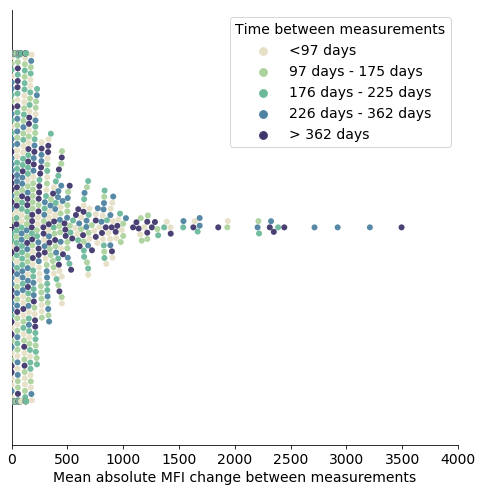

In [26]:
swarmplot(df_adhoc, hue_order_eq_2, cubehelix_pal, maxval=4000,
          savename='paper/figures/plots/swarmplot_mean_absolute_mfi_change_class2_cblind')

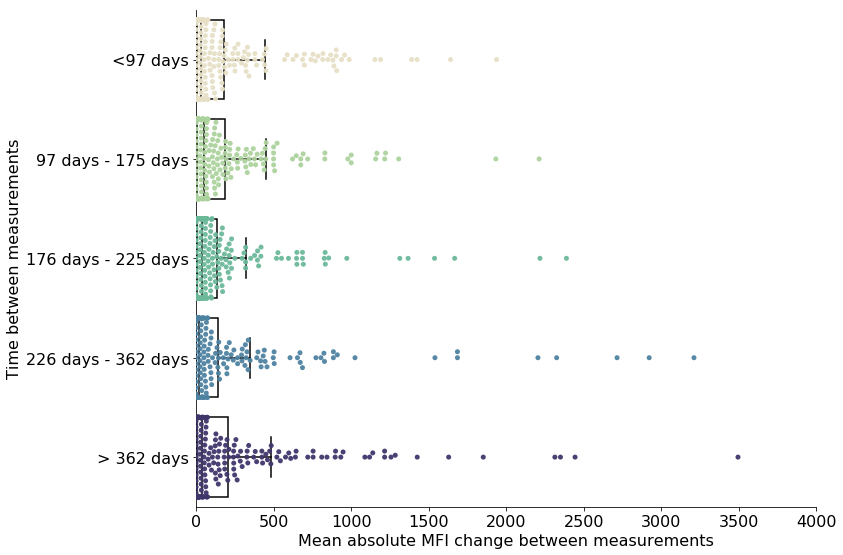

In [28]:
swarmboxplot(df_adhoc, hue_order_eq_2, cubehelix_pal, maxval=4000,
              savename='paper/figures/plots/swarmboxplot_mean_absolute_mfi_change_class2_cblind')

In [29]:
conduct_test(df_adhoc, hue_order_eq_2)

<97 days vs 97 days - 175 days:
	t-score: 0.363, p-val: 0.71681
<97 days vs 176 days - 225 days:
	t-score: 1.014, p-val: 0.31121
<97 days vs 226 days - 362 days:
	t-score: -0.126, p-val: 0.89956
<97 days vs > 362 days:
	t-score: -1.097, p-val: 0.27325
97 days - 175 days vs 176 days - 225 days:
	t-score: 0.672, p-val: 0.50188
97 days - 175 days vs 226 days - 362 days:
	t-score: -0.421, p-val: 0.67425
97 days - 175 days vs > 362 days:
	t-score: -1.405, p-val: 0.16082
176 days - 225 days vs 226 days - 362 days:
	t-score: -0.950, p-val: 0.34266
176 days - 225 days vs > 362 days:
	t-score: -1.921, p-val: 0.05541
226 days - 362 days vs > 362 days:
	t-score: -0.838, p-val: 0.40267


In [30]:
# Clinical cutoffs
times = np.concatenate(tdifs_2)
class2_dict_fig3 = dict()

for months in [3,4,6]:
    # Compute the two sets
    print("{} months".format(months))
    ind = (times<30*months).reshape(-1)
    ss1 = a[ind]
    ss2 = a[~ind]
    t, p = ttest_ind(ss1, ss2, equal_var=False, nan_policy='omit')
    # Save values for figure 3 plots
    class2_dict_fig3[months] = [ss1, ss2]
    print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))

3 months
	t-score: -0.292, p-val: 0.77056
4 months
	t-score: -0.538, p-val: 0.59098
6 months
	t-score: -0.676, p-val: 0.49940


# Figure 3
Plot on the p-values for clinical threshold time.

In [31]:
# For the different months, plot the bars
val_list = []
for months in [3, 4, 6]:
    # Class 1 values
    for i in [0,1]:
        c1 = np.vstack((class1_dict_fig3[months][i],
                        months*np.ones(len(class1_dict_fig3[months][i])),
                        i*np.ones(len(class1_dict_fig3[months][i])),
                        np.ones(len(class1_dict_fig3[months][i])))).T
        c2 = np.vstack((class2_dict_fig3[months][i],
                        months*np.ones(len(class2_dict_fig3[months][i])),
                        i*np.ones(len(class2_dict_fig3[months][i])),
                        2*np.ones(len(class2_dict_fig3[months][i])))).T
        val_list.extend(c1)
        val_list.extend(c2)

In [32]:
df_fig3 = pd.DataFrame(val_list, columns=['Mean absolute MFI change\nbetween measurements', 
                                          'Time interval (months)', 'above', 'Class'])
df_fig3.above = df_fig3.above.astype('category')
df_fig3['Class'] = df_fig3['Class'].astype('int')
df_fig3['Time interval (months)'] = df_fig3['Time interval (months)'].astype('int')

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


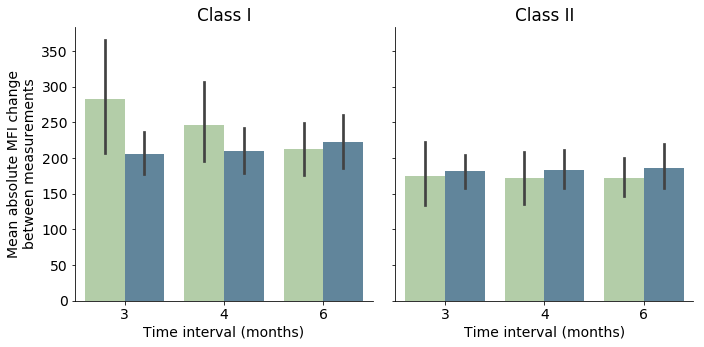

In [33]:
plt.rcParams.update({'font.size': 14})

ax = sns.catplot(x="Time interval (months)", y="Mean absolute MFI change\nbetween measurements", 
            hue="above", col='Class', data=df_fig3, kind='bar', legend=False,
            palette={0: cubehelix_pal[1], 1: cubehelix_pal[-2]}, alpha=0.95)
ax.axes[0][0].set_title('Class I')
ax.axes[0][1].set_title('Class II')
ax.savefig('paper/figures/plots/clinical_cutoffs_barplots.pdf', dpi=300, bbox_inches='tight')
ax.savefig('paper/figures/plots/clinical_cutoffs_barplots.png', bbox_inches='tight')

plt.rcParams.update({'font.size': 12})


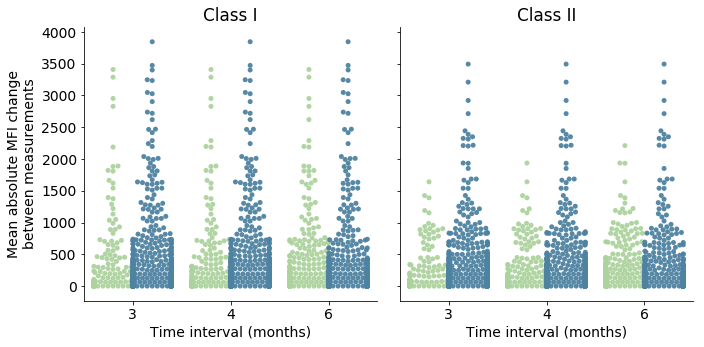

In [35]:
plt.rcParams.update({'font.size': 14})

ax = sns.catplot(x="Time interval (months)", y="Mean absolute MFI change\nbetween measurements", 
            hue="above", col='Class', data=df_fig3, legend=False, kind='swarm',
            palette={0: cubehelix_pal[1], 1: cubehelix_pal[-2]}, alpha=0.95, dodge=True)
ax.axes[0][0].set_title('Class I')
ax.axes[0][1].set_title('Class II')
plt.savefig('paper/figures/plots/clinical_time_cutoffs_swarmboxplots.pdf', dpi=300, bbox_inches='tight')
plt.savefig('paper/figures/plots/clinical_time_cutoffs_swarmboxplots.png', bbox_inches='tight')

plt.rcParams.update({'font.size': 12})

# Supplementary figures for patients without any immunizing events
The same analysis were conducted on a restricted set of patients and measurements that occured at least 1 month apart.

In [36]:
# function to identify measurements to be omitted
def remove_close_events(dates, thr=30):
    # Takes the *dates* and remove the ones closer than thr days
    # Can't do this with tidfs directly, we would lose a measurement.
    n = len(dates)
    # Compute tdifs
    tdifs = np.array([float(x.days) for x in dates[1:]-dates[:-1]]).reshape(-1,1)
    
    if n==2:
        if tdifs[0] < thr:
            # return only the first, discard patient
            return pd.DatetimeIndex(dates[0])
        else:
            return dates
    # Check for diffs, rule of thumb: always try to eliminate later date
    elim_dates = []
    tmp_dates = []
    for i, tdif in enumerate(tdifs):
        if tdif < thr:
            if i < n-2:
                # try removing the first
                d0 = remove_close_events(pd.DatetimeIndex(tmp_dates + list(dates[i+1:])), thr=thr)
                # try removing the second
                d1 = remove_close_events(pd.DatetimeIndex(tmp_dates + list([dates[i]]) + list(dates[i+2:])), thr=thr)
                best = d1 if len(d1) >= len(d0) else d0
            else:
                best = pd.DatetimeIndex(tmp_dates + [dates[i]])
            return best
        tmp_dates.append(dates[i])
    tmp_dates.append(dates[i+1])
    return pd.DatetimeIndex(tmp_dates)

In [37]:
# Load the list of transfusions
filename = "data/Transfusions_data_RS_nummer.csv"
df_immunizing = pd.read_csv(filename, encoding = "latin")
# df_immunizing.head()

In [38]:
# Start by cleaning off the data: RSNR remove asterisks
# Remove lines without RSNR
df_immunizing = df_immunizing[df_immunizing["RSNR"].notnull()]
# Remove asterisks
new_RSNR = []
for rn in df_immunizing['RSNR']:
    if rn[:2] == "**":
        new_RSNR.append(rn[2:-2])
    else:
        new_RSNR.append(rn)
df_immunizing.loc[:,'RSNR'] = new_RSNR

In [39]:
# Now filter and only keep RSNR of interest (i.e. that we kept in the analysis thus far.)
rsnr_of_interest = df_filtered['RSNR'].unique()
print("There are {} entries in the df_immunizing table before filtering".format(df_immunizing.shape[0]))
df_immunizing_filtered = df_immunizing[[d in rsnr_of_interest for d in df_immunizing["RSNR"]]]
print("There are {} entries in the df_immunizing table after filtering".format(df_immunizing_filtered.shape[0]))

print("This means we have some patients (467-433=34) for which no info about immunizing event is present.")

There are 618 entries in the df_immunizing table before filtering
There are 433 entries in the df_immunizing table after filtering
This means we have some patients (467-433=34) for which no info about immunizing event is present.


In [40]:
# 1. most stringent
print(df_immunizing_filtered['TRANSFUSION'].unique())
print(df_immunizing_filtered['SCHWANGERSCHAFT'].unique())
df_strict_filtering = df_immunizing_filtered[np.logical_and(df_immunizing_filtered['TRANSFUSION']=='Nein',
                                                            df_immunizing_filtered['SCHWANGERSCHAFT']=='Nein')]
print("Only {} patients remain after strict filtering.".format(df_strict_filtering.shape[0]))


['Unbekannt' 'Ja' 'Nein' nan]
['Unbekannt' 'Nein' 'Ja' nan]
Only 88 patients remain after strict filtering.


In [41]:
# Quick sanity check on the demographic of the selected patients
df_map = pd.read_csv("data/RS_nummer_age_sex.csv")
df_map = df_map[[x in df_strict_filtering['RSNR'].unique() for x in df_map['RS Number']]]
print(df_map.groupby('Sex').count())
# print(df_map.groupby('Unnamed: 1').count())

        RS Number  Unnamed: 1
Sex                          
Female         17          17
Male           71          71


In [42]:
# Let's check that we have enough info about those
tdifs_noshort_noimmuno = []
valdifs_noshort_noimmuno = []
kept_ids_noshort_noimmuno = []
for patid in df_strict_filtering['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # SKIP MEASUREMENTS TOO CLOSE
        patient_ts = patient_ts[[x in remove_close_events(patient_ts.index) for x in patient_ts.index]]
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs_noshort_noimmuno.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs_noshort_noimmuno.append(patient_ts.as_matrix()[1:,:]-patient_ts.as_matrix()[:-1,:])
        kept_ids_noshort_noimmuno.append(patid)
    except:
        continue

print("There were {} patients when accounting for all measurements, avg. len: {}".format(len(valdifs_noshort_noimmuno), 
                                                                                         np.mean([len(x) for x in valdifs_noshort_noimmuno])))


There were 82 patients when accounting for all measurements, avg. len: 2.2560975609756095


In [43]:
# Equal size
t = np.concatenate(tdifs_noshort_noimmuno)
lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq_noshort_noimmuno = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq_noshort_noimmuno[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq_noshort_noimmuno[(t>=lims[-1]).reshape(-1,)] = i+1

print(lims)

print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))

class_label_eq_noshort_noimmuno = class_label_eq_noshort_noimmuno.astype(int)
class_dict_eq_noshort_noimmuno = {
    0: '<140 days',
    1: '140 days - 187 days',
    2: '188 days - 255 days',
    3: '256 days - 365 days',
    4: '>365 days'
}
hue_order_eq_noshort_noimmuno=['<140 days', '140 days - 187 days','188 days - 255 days','256 days - 365 days','>365 days']
class_lab_eq_noshort_noimmuno = []
for c in class_label_eq_noshort_noimmuno:
    class_lab_eq_noshort_noimmuno.append(class_dict_eq_noshort_noimmuno[c])

np.unique(class_label_eq_noshort_noimmuno)


[139.8 187.  255.2 365.2]
There are 185 total differences, 37.0 in each quantile.


array([0, 1, 2, 3, 4])

In [44]:
sum_abs_vectors_noimmuno = [np.abs(x).T.mean(axis=0) for x in valdifs_noshort_noimmuno] # Dont forget to transpose the time series!

a_noimmuno = np.concatenate(sum_abs_vectors_noimmuno)
a_z = a_noimmuno[a_noimmuno<1500] # Remove the one outlier at 1750
df_adhoc = pd.DataFrame(np.abs(a_z).T, columns=['Mean absolute MFI change between measurements'])
df_adhoc['Time between measurements'] = np.array(class_lab_eq_noshort_noimmuno)[a_noimmuno<1500]


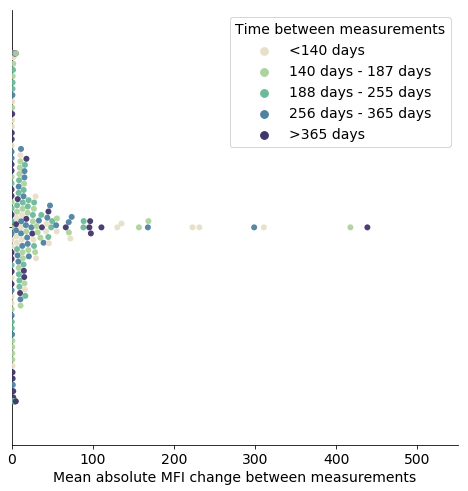

In [45]:
swarmplot(df_adhoc, hue_order_eq_noshort_noimmuno, cubehelix_pal, maxval=550,
          savename='paper/figures/plots/swarmplot_mean_absolute_mfi_change_noimmuno_cblind')

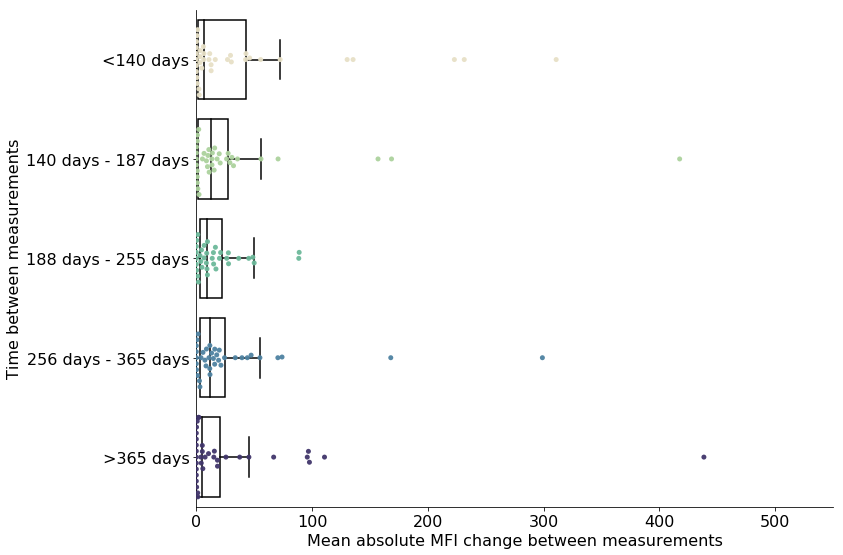

In [46]:
swarmboxplot(df_adhoc, hue_order_eq_noshort_noimmuno, cubehelix_pal, maxval=550,
          savename='paper/figures/plots/swarmboxplot_mean_absolute_mfi_change_noimmuno_cblind')

In [48]:
vs = []
for c in hue_order_eq_noshort_noimmuno:
    vs.append(df_adhoc[df_adhoc['Time between measurements']==c]['Mean absolute MFI change between measurements'].as_matrix())
# Conduct the test for each pair
for i in range(5):
    for j in range(i+1,5):
        print('{} vs {}:'.format(hue_order_eq_noshort_noimmuno[i], hue_order_eq_noshort_noimmuno[j]))
        t, p = ttest_ind(vs[i], vs[j], equal_var=False, nan_policy='omit')
        print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))


<140 days vs 140 days - 187 days:
	t-score: 0.417, p-val: 0.67765
<140 days vs 188 days - 255 days:
	t-score: 1.771, p-val: 0.08365
<140 days vs 256 days - 365 days:
	t-score: 0.717, p-val: 0.47584
<140 days vs >365 days:
	t-score: 0.490, p-val: 0.62537
140 days - 187 days vs 188 days - 255 days:
	t-score: 1.213, p-val: 0.23153
140 days - 187 days vs 256 days - 365 days:
	t-score: 0.248, p-val: 0.80525
140 days - 187 days vs >365 days:
	t-score: 0.087, p-val: 0.93078
188 days - 255 days vs 256 days - 365 days:
	t-score: -1.172, p-val: 0.24689
188 days - 255 days vs >365 days:
	t-score: -1.027, p-val: 0.31032
256 days - 365 days vs >365 days:
	t-score: -0.140, p-val: 0.88932


In [49]:
times = np.concatenate(tdifs_noshort_noimmuno)
for months in [3,4,6]:
    # Compute the two sets
    print("{} months".format(months))
    ind = (times<30*months).reshape(-1)
    ss1 = a_noimmuno[ind]
    ss2 = a_noimmuno[~ind]
    t, p = ttest_ind(ss1, ss2, equal_var=False, nan_policy='omit')
    print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))

3 months
	t-score: 0.072, p-val: 0.94292
4 months
	t-score: 0.145, p-val: 0.88502
6 months
	t-score: 0.127, p-val: 0.89899


### Class 2


In [50]:
# Let's check that we have enough info about those
tdifs_noshort_noimmuno_type2 = []
valdifs_noshort_noimmuno_type2 = []
selected_rsnr_noshort_noimmuno = []
for patid in df_strict_filtering['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ2.loc[patid], complete=True, analysis_type='2')
        # SKIP MEASUREMENTS TOO CLOSE
        patient_ts = patient_ts[[x in remove_close_events(patient_ts.index) for x in patient_ts.index]]
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs_noshort_noimmuno_type2.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs_noshort_noimmuno_type2.append(patient_ts.as_matrix()[1:,:]-patient_ts.as_matrix()[:-1,:])
        selected_rsnr_noshort_noimmuno.append(patid)
    except:
        continue

print("There were {} patients when accounting for all measurements, avg. len: {}".format(len(valdifs_noshort_noimmuno_type2), 
                                                                                         np.mean([len(x) for x in valdifs_noshort_noimmuno_type2])))


There were 75 patients when accounting for all measurements, avg. len: 2.3866666666666667


In [51]:
# Equal size
t = np.concatenate(tdifs_noshort_noimmuno_type2)
lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq_noshort_noimmuno_type2 = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq_noshort_noimmuno_type2[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq_noshort_noimmuno_type2[(t>=lims[-1]).reshape(-1,)] = i+1

print(lims)

print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))

class_label_eq_noshort_noimmuno_type2 = class_label_eq_noshort_noimmuno_type2.astype(int)
class_dict_eq_noshort_noimmuno_type2 = {
    0: '<133 days',
    1: '133 days - 187 days',
    2: '188 days - 265 days',
    3: '266 days - 365 days',
    4: '>365 days'
}
hue_order_eq_noshort_noimmuno_type2 = ['<133 days','133 days - 187 days','188 days - 265 days','266 days - 365 days','>365 days']
class_lab_eq_noshort_noimmuno_type2 = []
for c in class_label_eq_noshort_noimmuno_type2:
    class_lab_eq_noshort_noimmuno_type2.append(class_dict_eq_noshort_noimmuno_type2[c])

np.unique(class_label_eq_noshort_noimmuno_type2)


[133.  187.  265.  365.2]
There are 179 total differences, 35.8 in each quantile.


array([0, 1, 2, 3, 4])

In [52]:
sum_abs_vectors_noimmuno_typ2 = [np.abs(x).T.mean(axis=0) for x in valdifs_noshort_noimmuno_type2] # Dont forget to transpose the time series!

a_noimmuno = np.concatenate(sum_abs_vectors_noimmuno_typ2)
a_z = a_noimmuno
df_adhoc = pd.DataFrame(np.abs(a_z).T, columns=['Mean absolute MFI change between measurements'])
df_adhoc['Time between measurements'] = np.array(class_lab_eq_noshort_noimmuno_type2)


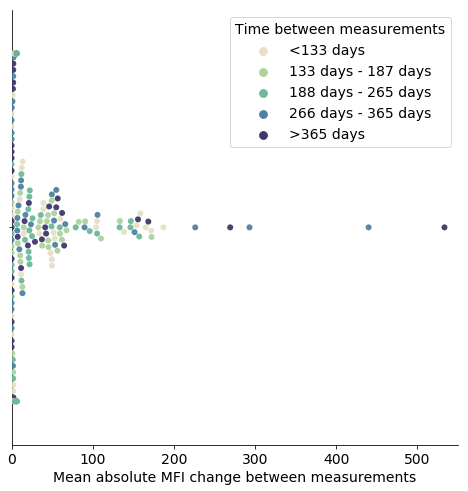

In [53]:
swarmplot(df_adhoc, hue_order_eq_noshort_noimmuno_type2, cubehelix_pal, maxval=550,
          savename='paper/figures/plots/swarmplot_mean_absolute_mfi_change_noimmuno_class2_cblind')

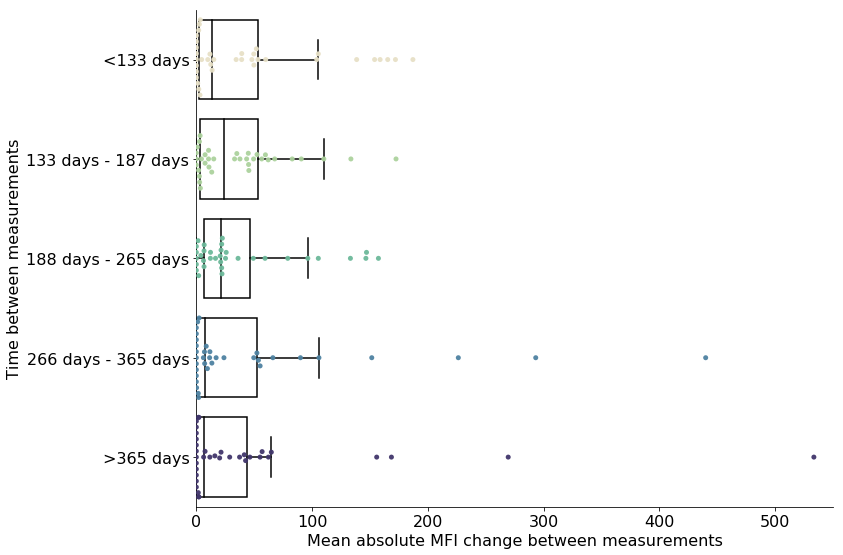

In [54]:
swarmboxplot(df_adhoc, hue_order_eq_noshort_noimmuno_type2, cubehelix_pal, maxval=550,
          savename='paper/figures/plots/swarmboxplot_mean_absolute_mfi_change_noimmuno_class2_cblind')

In [56]:
# Test the distribution differences using indep ttest
vs = []
for c in hue_order_eq_noshort_noimmuno_type2:
    vs.append(df_adhoc[df_adhoc['Time between measurements']==c]['Mean absolute MFI change between measurements'].as_matrix())
# Conduct the test for each pair
for i in range(5):
    for j in range(i+1,5):
        print('{} vs {}:'.format(hue_order_eq_noshort_noimmuno_type2[i], hue_order_eq_noshort_noimmuno_type2[j]))
        t, p = ttest_ind(vs[i], vs[j], equal_var=False, nan_policy='omit')
        print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))

print()
# Clinical cutoffs
times = np.concatenate(tdifs_noshort_noimmuno_type2)
for months in [3,4,6]:
    # Compute the two sets
    print("{} months".format(months))
    ind = (times<30*months).reshape(-1)
    ss1 = a_noimmuno[ind]
    ss2 = a_noimmuno[~ind]
    t, p = ttest_ind(ss1, ss2, equal_var=False, nan_policy='omit')
    print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))

<133 days vs 133 days - 187 days:
	t-score: 0.762, p-val: 0.44897
<133 days vs 188 days - 265 days:
	t-score: 0.620, p-val: 0.53719
<133 days vs 266 days - 365 days:
	t-score: -0.091, p-val: 0.92756
<133 days vs >365 days:
	t-score: -0.013, p-val: 0.98960
133 days - 187 days vs 188 days - 265 days:
	t-score: -0.109, p-val: 0.91364
133 days - 187 days vs 266 days - 365 days:
	t-score: -0.629, p-val: 0.53248
133 days - 187 days vs >365 days:
	t-score: -0.513, p-val: 0.61052
188 days - 265 days vs 266 days - 365 days:
	t-score: -0.542, p-val: 0.59027
188 days - 265 days vs >365 days:
	t-score: -0.435, p-val: 0.66522
266 days - 365 days vs >365 days:
	t-score: 0.062, p-val: 0.95064

3 months
	t-score: -0.621, p-val: 0.53905
4 months
	t-score: 0.744, p-val: 0.46024
6 months
	t-score: -0.368, p-val: 0.71302
